# Datas 

- Source for airports locations: https://openflights.org/data.html (file airlines.dat)
- Source for american airlines and flight scedules: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236


In [51]:
from visuMultiStream import *
print("1")
from intervals import *
print("2")
from structure import *
print("3")
from elemMSGraph import *
print("4")
from multiLayers import *
print("5")
from sortedcollection import *
print("6")
from matrices import *
print("7")
from random import *
print("8")
import seaborn as sns
print("9")

from tulip import tlp
print("10")
import scipy.linalg
print("finished")

1
2
3
4
5
6
7
8
9
10
finished


Echelle de temps : 1 mois

In [52]:
t0=0
tend=24*60*31

print(tend)

interval=Interval(t0,tend)

44640


In [53]:
def convertToMinutes(day,hour,minutes):
    return((day-1)*24*60+hour*60+minutes)



def readAirports(airportl):
    dicoAir={}
    f=open("planes/airports.dat","r",encoding="utf8")
    #print(f)
    lste=[]
    for line in f:
        line=line.replace("\"",'')
        tab=line.split(",")
        ida=tab[4]
        namea=tab[1]
        country=tab[3]
        #print(ida)
        if (ida in dicoAir)==False and (ida in airportl):
            lat=tab[6]
            long=tab[7]
            dicoAir[ida]=[namea,lat,long]
            lste.append(NodeT(ida,IntervalList([interval])))
    return(dicoAir,lste)
    

def readLinks():
    f=open("planes/linksmonth201901.csv",'r')
    n=0
    em=LinkList([])
    careersl=[]
    airportl=[]
    airportPerLay={}
    for line in f:
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            date=int(tab[0].split("-")[2])
            career=tab[1]
            origin=tab[2]
            dest=tab[3]
            dept=int(tab[4][0]+tab[4][1])*60+int(tab[4][2]+tab[4][3])
            if len(tab[5])>0:
                arrival=int(tab[6][0]+tab[6][1])*60+int(tab[6][2]+tab[6][3])
                inter=Interval((date-1)*24*60+dept,(date-1)*24*60+arrival)
                if arrival<=dept:
                    inter=Interval((date-1)*24*60+dept,(date)*24*60+arrival)
                if not (career in careersl):
                    careersl.append(career)
                if not (origin in airportl):
                    airportl.append(origin)
                if not (dest in airportl):
                    airportl.append(dest)
                if (career in airportPerLay.keys())==False:
                    airportPerLay[career]=[]
                if not origin in airportPerLay[career]:
                    airportPerLay[career].append(origin)
                if not dest in airportPerLay[career]:
                    airportPerLay[career].append(dest)
                em.addLink(Link(IntervalList([inter]),NodeT(origin,IntervalList([interval])),[career],NodeT(dest,IntervalList([interval])),[career],directed=1),cond=0)
        n=n+1
    return(em,sorted(careersl),sorted(airportl),airportPerLay)

    
def readCarriers(carL):
    f=open("planes/L_UNIQUE_CARRIERS.csv","r")
    n=0
    liste=[]
    dicoCarreer={}
    for line in f :
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            tab[-1]=tab[-1].rstrip("\n")
            code=tab[0]
            name=tab[1]
            if (code in liste) == False and (code in carL)==True :
                liste.append(code)
                dicoCarreer[code]=name
        n=n+1
    comp=Aspect("carrier",liste)
    return(comp,dicoCarreer)

# Principe :

In the datasets, they are to many airports and carriers (not american and unused). So we begin to read the links to know which airports and carriers are used and we then read their datasets to collect their detailed informations (stored into dictionnaries)

In [54]:
em,carL,airportl,airportperlay=readLinks()

dicoAir,nodes=readAirports(airportl)

laystr=LayerStruct([Aspect("compagnies",carL)])
listLay=[]

carriers,dicoCarreer =readCarriers(carL)

for l in carriers.giveElemLayer():
    nl=NodeTList([])
    for no in airportperlay[l]:
        nl.addNodeT(NodeT(no,IntervalList([interval])))
    listLay.append(Layer(laystr,[l],interval,nl))

layers=LayerList(listLay)

m=MultiStream(interval,laystr,layers,em,nodes=airportl)          

multi=m.extractML()

extracting...
layer ['9E']
layer ['AA']
layer ['AS']
layer ['B6']
layer ['DL']
layer ['EV']
layer ['F9']
layer ['G4']
layer ['HA']
layer ['MQ']
layer ['NK']
layer ['OH']
layer ['OO']
layer ['UA']
layer ['WN']
layer ['YV']
layer ['YX']


In [55]:
m2=m.cut(Interval(0,24*60))
m2=m2.extractLayers([["G4"]])
m2.drawMS("avions.fig")

## Build the tulip file

The differents layers corresponding to the different carriers are drawn in different colors. We build different subgraphs corresponding to each company.

This is very useful for vizualisation (download tulip http://tulip.labri.fr/TulipDrupal/ ) to open the graph (double click on the graph on the bottom left and chose the "geographic view"

In [56]:
def makeGraph(m,airportl,carL,dicoAir,airportperlay):
    graph=tlp.newGraph()
    latitude=graph.getDoubleProperty("latitude")
    longitude=graph.getDoubleProperty("longitude")
    name = graph.getStringProperty("nameCity")
    code = graph.getStringProperty("code")
    couche = graph.getStringVectorProperty("compagnie")
    color = graph.getColorProperty("viewColor")
    k=len(carL)
    colList=[(randint(0,255),randint(0,255),randint(0,255)) for i in range(k)]
    for n in range(len(airportl)):
        graph.addNode()
        no=graph.nodes()[n]
        code[no]=airportl[n]
        listeAttributs=dicoAir[airportl[n]]
        name[no]=listeAttributs[0]
        latitude[no]=float(listeAttributs[1])
        longitude[no]=float(listeAttributs[2])
    n=0
    for lay in m.giveLayers().giveLayers():
        car=lay.giveLayerLabel()[0]
        sub=graph.addSubGraph(car)
        nliste=airportperlay[car]
        for node1 in nliste :
            no=graph.nodes()[airportl.index(node1)]
            sub.addNode(no)
        #print(car,len(sub.nodes()))
    for e in m.giveLinks().giveListOfLinks():
        n1=graph.nodes()[airportl.index(e.giveNodes()[0].giveNode())]
        n2=graph.nodes()[airportl.index(e.giveNodes()[1].giveNode())]
        graph.addEdge(n1,n2)
        ed=graph.edges()[n]
        n=n+1
        couche[ed]=e.giveLabel()[2]
        color[ed]=colList[carL.index(e.giveLabel()[2][0])]
        sub=graph.subGraphs()[carL.index(e.giveLabel()[2][0])]
        car=e.giveLabel()[2][0]
        codenode=e.giveNodes()[0].giveNode()
        n1=sub.nodes()[airportperlay[car].index(codenode)]
        n2=sub.nodes()[airportperlay[e.giveLabel()[2][0]].index(e.giveNodes()[1].giveNode())]
        sub.addEdge(ed)
    tlp.saveGraph(graph,"grapheplanes.tp")
    return(graph)

graph=makeGraph(m,airportl,carL,dicoAir,airportperlay)

We can then use the library "tulip" to compute classical measures: 

- page ranking: 

In [57]:
pagerank=graph.getDoubleProperty("pageRank")
params = tlp.getDefaultPluginParameters('Page Rank', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Page Rank', pagerank, params)
pr=[]
for n in graph.getNodes():
    pr.append(pagerank[n])

- betweenness centrality:

In [58]:
betweenness=graph.getDoubleProperty("betweeness")
params = tlp.getDefaultPluginParameters('Betweenness Centrality', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Betweenness Centrality', betweenness, params)
bt=[]
for n in graph.getNodes():
    bt.append(betweenness[n]) 

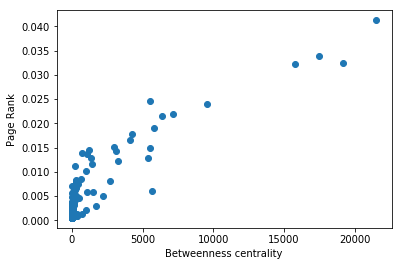

In [59]:
axes = plt.gca()
plt.plot(bt,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('Betweenness centrality')
plt.savefig("prVSbc.pdf")
plt.show()


# Intrication

We compute the Burt's matrix which is:

$\begin{pmatrix}
P(1) & P(1|2) & P(1|3) & \dots & P(1|n)\\
P(2|1) & P(2) & P(2|3) & \dots & P(2|n)\\
\vdots & \vdots & \ddots\\
\dots & \dots & \dots & \dots & P(n)
\end{pmatrix}$

$P(i)$ is the probability, taking a flight, that it exists in the compagny $C_i$.

$P(i|j)$ is the probability, taking a flight in $c_j$, that $c_i$ has the same flight.

In [60]:
matintric=multi.computeIntricationMatrixBurt()

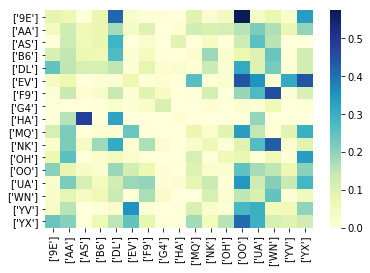

In [61]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matintric),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("intricplanes.pdf")
plt.show()


We compute its maximal left eigenvalue and the eigenvector associated. If the matrix isn't reductible (if we have all the nodes in the same connex component), this eigenvalue is unique and the eigenvector has all its coefficients of the same sign.

In [62]:
valp,vectp=valeurPropreMax(np.transpose(matintric),1000)

We draw the eigenvector ordered:

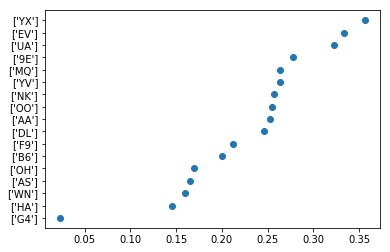

In [63]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectp[lablist.index(lab)])
vectpo,labo=l.listsSorted()

plt.plot(labo,vectpo,'o')
plt.savefig("intricscoresplanes.pdf")
plt.show()

 # Covariance

In [64]:
matcov=multi.computeCovariance()

N= 2777


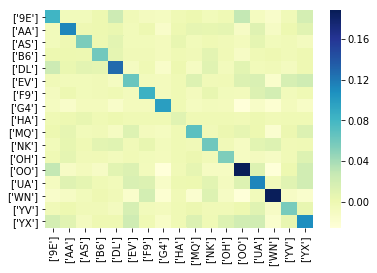

In [65]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matcov),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()

In [66]:
valpcov,vectpcov=valeurPropreMax(np.transpose(matcov),1000)
print(valpcov)

0.24319570569859572


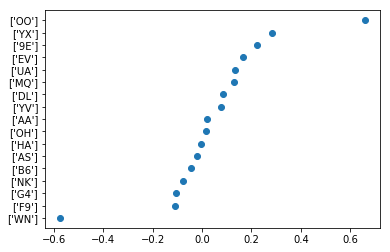

0.24319570569859572


In [67]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpcov[lablist.index(lab)])
vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
plt.savefig("covscoresplanes.pdf")
plt.show()

print(valpcov)

## Test: covariance valeur propre minimale

In [68]:
vp,vectpro=np.linalg.eig(matcov)

taux=[matintric[i][i] for i in range(len(matcov))]

print(vp,vectpro)

for i in range(len(vectpro)):
    esp=0
    for j in range(len(vectpro[i])):
        esp=esp+vectpro[i][j]*taux[j]
    print("esp",esp, "lambda", vp[i])
    
esp_glob=0
for i in range(len(taux)):
    esp_glob=esp_glob+taux[i]
print("esperance globale=",esp_glob)
print("variance globale = ", )

[0.24319571 0.1866247  0.15512387 0.14576064 0.0103496  0.11018582
 0.10335729 0.08490164 0.03376017 0.0381942  0.07666925 0.04733486
 0.05253715 0.06799162 0.06005574 0.06082589 0.06404466] [[-0.22073867  0.11121548 -0.21346488  0.18025907 -0.01415065  0.25559651
   0.20349737  0.16868788 -0.2242464  -0.18197577 -0.02151906  0.12714342
   0.07560632  0.21496307 -0.65654094 -0.37363192  0.05334766]
 [-0.02197596 -0.10642887  0.37821769  0.40643746 -0.00298469  0.18383982
  -0.67375776  0.23898574 -0.05995859 -0.08106763  0.27862009  0.03377809
  -0.13328082 -0.10498746 -0.12669186  0.03184258 -0.0170939 ]
 [ 0.01878084 -0.02488859 -0.01239686  0.11069212  0.08170232 -0.19138779
  -0.03898154 -0.23825417 -0.43435268  0.05735193 -0.00759842  0.52011562
  -0.37057729  0.23870631  0.22119348 -0.07755114  0.41623766]
 [ 0.04324019 -0.01192086 -0.02191426  0.1602092  -0.02870532  0.01684608
   0.05210875 -0.14725608 -0.23986773  0.05381958 -0.07734905 -0.38229699
  -0.47982582  0.44230166 -0

## Tests precision

In [69]:
matprec=np.linalg.inv(matcov)
#for i in range(len(matprec)):
#    matprec[i][i]=0

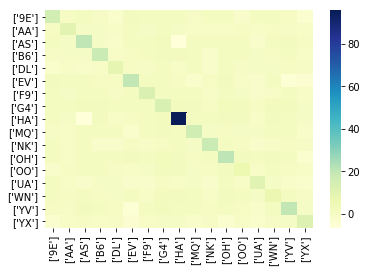

In [70]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matprec),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()

In [71]:
valpprec,vectpprec=valeurPropreMax(np.transpose(matprec),1000)
print(1/valpprec)

0.01034959619041909


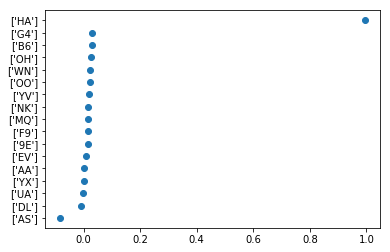

96.62212724064808


In [72]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpprec[lablist.index(lab)])


vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
plt.savefig("precscoresplanes.pdf")
plt.show()

print(valpprec)

## Next VP

[[-8.14812670e+01  9.65999986e-01  1.65367737e+00  1.99294205e-03
  -2.43131150e+00  2.13384579e+00  1.15146760e+00  1.40298318e+00
   1.13825022e+00  8.42079229e-02  1.01714428e+00  1.20518569e+00
  -1.50964027e+00  1.23161327e+00  1.18167083e+00  6.53250207e-01
  -2.77769435e+00]
 [ 9.65999986e-01 -8.70277350e+01  4.77929834e-01  2.41539872e-01
  -2.91756133e-01  1.45801989e+00  1.81616399e-01  1.65767003e+00
   2.07563893e-01 -6.78075359e-01 -5.69091891e-01 -6.03917993e-01
   8.63381856e-01 -8.39597389e-01  8.74604019e-01 -1.21146528e-01
  -8.01434930e-01]
 [ 1.65367737e+00  4.77929834e-01 -7.64106519e+01  4.30273108e-01
  -1.08717932e+00  1.17208281e+00  1.63660122e+00  2.41814076e+00
  -6.61493858e+00  1.25456708e+00  1.20632767e+00  1.68933292e+00
   1.07262819e+00 -1.68288474e+00  1.26163450e+00  1.78005489e+00
   9.40007286e-01]
 [ 1.99294205e-03  2.41539872e-01  4.30273108e-01 -7.90384851e+01
  -5.22960041e-01  6.87986192e-01  1.16224296e+00  2.10485572e+00
   2.11515742e+00  

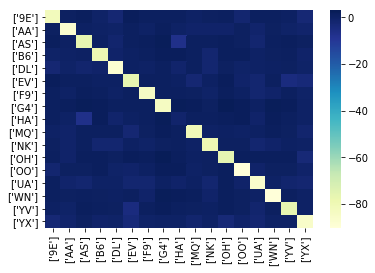

In [73]:
matprec2=matprec-valpprec*np.eye(17)
print(matprec2)

lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matprec2),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()


In [74]:
valpp2,vectpp2=valeurPropreMax(np.transpose(matprec2),1000)

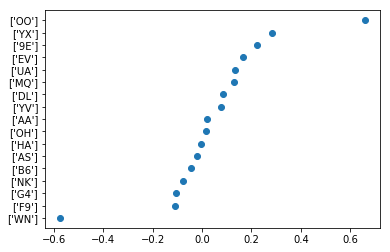

189.13233976993962


In [75]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpp2[lablist.index(lab)])


vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
#plt.savefig("precscoresplanes.pdf")
plt.show()

print(valpp2+valpprec)

# Random walks

A step: to go on, a passenger will chose among all the possibles links he can take. Each link corresponds to a company and a destination.

For instance, from `['Montgomery Regional (Dannelly Field) Airport', '32.30059814', '-86.39399719']`
we can reach with the same probability:
```
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with Endeavor Air Inc.
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with SkyWest Airlines Inc.
['Ronald Reagan Washington National Airport', '38.8521', '-77.037697'] with PSA Airlines Inc.
['Dallas Fort Worth International Airport', '32.896801', '-97.038002'] with Envoy Air
```


In [76]:
def step(pos0,airportl,m,t,prints=False):
    if prints==True:
        print(dicoAir[pos0])
    bloque=False
    possibleDest={}
    listDest=[]
    car="none"
    for link in m.giveLinks().giveListOfLinks():
        if link.giveNodes()[0].giveNode()==pos0:
            dest=link.giveNodes()[1].giveNode()
            if not dest in listDest:
                listDest.append(dest)
                possibleDest[dest]=[]
            possibleDest[dest].append(link)
            #print(link.giveLabel())
            #print(dicoAir[(link.giveLabel()[1])],dicoCarreer[link.giveLabel()[2][0]])
    if len(listDest)==0:
        bloque=True
        pos1=pos0
        print("no neighbours")
        t1=t
    else:
        #print("----------------------------")
        li=randint(0,len(listDest)-1)
        operListe=possibleDest[listDest[li]]
        link0i=randint(0,len(operListe)-1)
        link0=operListe[link0i]
        #link0.printLink()
        #print(link0.giveLabel())
        pos1=link0.giveNodes()[1].giveNode()
        intervalsL=link0.giveIntervals()
        i=0
        car=link0.giveLabel()[2][0]
        while i<len(intervalsL) and intervalsL[i].begining()<t :
            i=i+1
        if i==len(intervalsL):
            bloque=True
            t1=t
            print("timeout")
        else:
            t1=intervalsL[i].end()
    return(pos1,t1,car,bloque)

pos0=airportl[randint(0,len(airportl)-1)]
step(pos0,airportl,m,0)

('ANC', 2698, 'AS', False)

From that, we compute the random walk: 

In [77]:
def randomWalk(airportl,m,t,collect="coverage",prints=False,boucles=1):
    pos0=airportl[randint(0,len(airportl)-1)]
    t=0
    bloque=False
    i=0
    b=0
    if collect=="coverage":
        airports=np.array([0 for i in range(len(airportl))])
        compagnies=np.array([0 for i in range(len(carL))])
    if collect=="firstTimeToReach":
        airports=np.array([tend for i in range(len(airportl))])
        compagnies=np.array([tend for i in range(len(carL))])
    while bloque==False and b<boucles:
        if prints==True:
            print(pos0,t)
        pos0,t,car,bloque=step(pos0,airportl,m,t,prints=prints)
        if bloque==True:
            b=b+1
            t=0
            bloque=False
        if collect=="coverage":
            airports[airportl.index(pos0)]=airports[airportl.index(pos0)]+1
            compagnies[carL.index(car)]=compagnies[carL.index(car)]+1
        if collect=="firstTimeToReach":
            if airports[airportl.index(pos0)]==tend:
                airports[airportl.index(pos0)]=t
            if compagnies[carL.index(car)]== tend:
                compagnies[carL.index(car)]=t
        i=i+1
    return([pos0,t,airports,compagnies])

randomWalk(airportl,m,0,prints=True,boucles=10)

LAS 0
['McCarran International Airport', '36.08010101', '-115.1520004']
DCA 1260
['Ronald Reagan Washington National Airport', '38.8521', '-77.037697']
CMH 2195
['John Glenn Columbus International Airport', '39.998001', '-82.891899']
IAH 3404
['George Bush Intercontinental Houston Airport', '29.984399795532227', '-95.34140014648438']
RDU 4203
['Raleigh Durham International Airport', '35.877601623535156', '-78.7874984741211']
DAL 5190
['Dallas Love Field', '32.847099', '-96.851799']
SEA 5440
['Seattle Tacoma International Airport', '47.449001', '-122.308998']
HNL 6538
['Daniel K Inouye International Airport', '21.32062', '-157.924228']
GUM 6905
['Antonio B. Won Pat International Airport', '13.4834003448', '144.796005249']
SPN 7691
['Saipan International Airport', '15.119', '145.729004']
GUM 7795
['Antonio B. Won Pat International Airport', '13.4834003448', '144.796005249']
SPN 9131
['Saipan International Airport', '15.119', '145.729004']
GUM 9235
['Antonio B. Won Pat International Airpo

timeout
ORD 0
["Chicago O'Hare International Airport", '41.9786', '-87.9048']
BOI 847
['Boise Air Terminal/Gowen Field', '43.5644', '-116.223']
SJC 2109
['Norman Y. Mineta San Jose International Airport', '37.362598', '-121.929001']
LIH 3693
['Lihue Airport', '21.97599983215332', '-159.33900451660156']
PHX 4690
['Phoenix Sky Harbor International Airport', '33.43429946899414', '-112.01200103759766']
BUR 4765
['Bob Hope Airport', '34.20069885253906', '-118.35900115966797']
DEN 5310
['Denver International Airport', '39.861698150635', '-104.672996521']
LAR 5717
['Laramie Regional Airport', '41.31209945678711', '-105.67500305175781']
DEN 6193
['Denver International Airport', '39.861698150635', '-104.672996521']
PNS 9260
['Pensacola Regional Airport', '30.473400115967', '-87.186599731445']
timeout
ORD 0
["Chicago O'Hare International Airport", '41.9786', '-87.9048']
SGF 707
['Springfield Branson National Airport', '37.24570084', '-93.38860321']
SFB 2142
['Orlando Sanford International Airpor

['VPS',
 0,
 array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3,
        5, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0,
        2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 2, 6, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 1, 1, 0, 1, 2, 0, 3, 0, 0, 3, 0, 0, 7, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 5, 0, 1, 6, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5,
        0, 0, 0, 1, 0, 0, 

We compute then a great amount of random walks, collecting several informations:

- the coverage

In [78]:
covAirports=np.array([0 for i in range(len(airportl))])
covCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(30):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    covAirports=np.add(covAirports,airports)
    covCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 10
timeout
timeout
timeout
timeout
ti

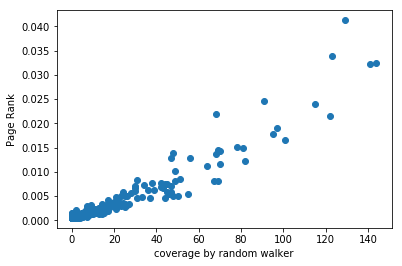

In [79]:
axes = plt.gca()
plt.plot(covAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('coverage by random walker')
plt.savefig("prVSrw.pdf")
plt.show()

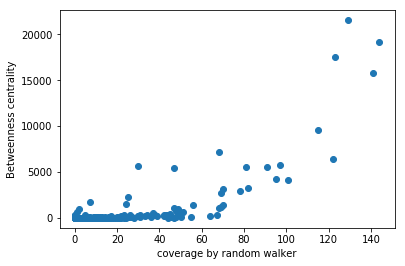

In [80]:
axes = plt.gca()
plt.plot(covAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('coverage by random walker')
plt.savefig('bcVScovrw.pdf')
plt.show()

[183 315 192 175 366 128 252 541  39 198 164 197 675 275 822 129 211]
[0.27801714 0.25277487 0.16536946 0.19956213 0.24586113 0.33334731
 0.21209387 0.02362059 0.14503349 0.26303856 0.25672139 0.1693862
 0.25422656 0.32186742 0.16000328 0.26291929 0.35602027]


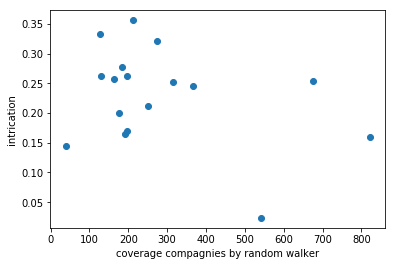

In [81]:
print(covCompagnies)
print(vectp)
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
plt.show()


- the first time to reach

In [82]:
ftrAirports=np.array([0 for i in range(len(airportl))])
ftrCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(10):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,collect="firstTimeToReach",boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    ftrAirports=np.add(covAirports,airports)
    ftrCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout


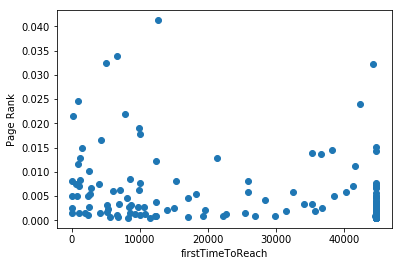

In [83]:
axes = plt.gca()
plt.plot(ftrAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('firstTimeToReach')
plt.show()

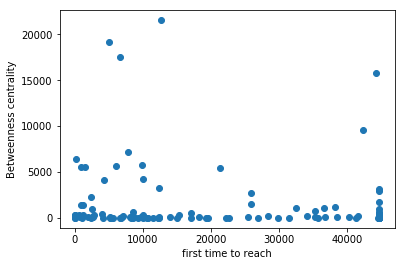

In [84]:
axes = plt.gca()
plt.plot(ftrAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('first time to reach')
plt.show()

In [85]:
nnodes=[121,102,70,68,145,101,90,120,18,134,43,95,239,108,85,103,87]
nlinks=[488,721,326,362,834,368,522,614,62,419,366,325,1358,715,1378,335,661]

['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']


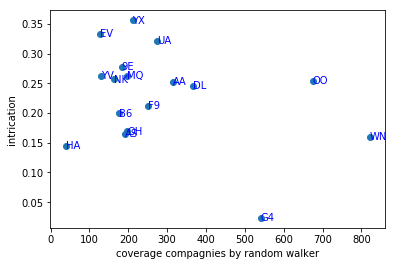

In [86]:
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(carL)
ni=0
for i in carL:
    text = axes.text(covCompagnies[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()


[1.512396694214876, 3.088235294117647, 2.742857142857143, 2.573529411764706, 2.524137931034483, 1.2673267326732673, 2.8, 4.508333333333334, 2.1666666666666665, 1.4776119402985075, 3.813953488372093, 2.0736842105263156, 2.8242677824267783, 2.5462962962962963, 9.670588235294117, 1.2524271844660195, 2.425287356321839]


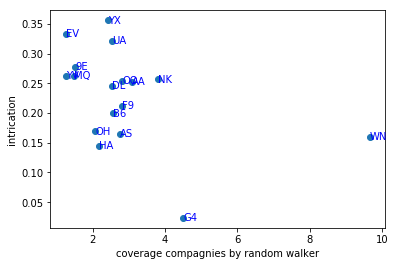

In [87]:
cov2=[covCompagnies[i]/nnodes[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov2,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(cov2)
ni=0
for i in carL:
    text = axes.text(cov2[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

[-0.375, -0.4368932038834951, -0.588957055214724, -0.48342541436464087, -0.43884892086330934, -0.34782608695652173, -0.4827586206896552, -0.8811074918566775, -0.6290322580645161, -0.47255369928400953, -0.44808743169398907, -0.6061538461538462, -0.49705449189985274, -0.38461538461538464, -0.5965166908563135, -0.3850746268656716, -0.31921331316187596]


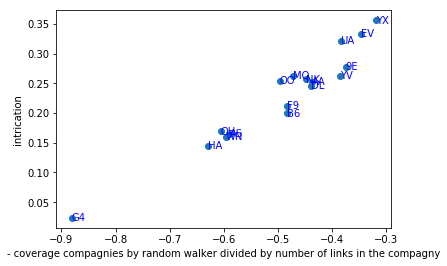

In [88]:
cov3=[-covCompagnies[i]/nlinks[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('- coverage compagnies by random walker divided by number of links in the compagny')
print(cov3)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

[-0.375, -0.4368932038834951, -0.588957055214724, -0.48342541436464087, -0.43884892086330934, -0.34782608695652173, -0.4827586206896552, -0.8811074918566775, -0.6290322580645161, -0.47255369928400953, -0.44808743169398907, -0.6061538461538462, -0.49705449189985274, -0.38461538461538464, -0.5965166908563135, -0.3850746268656716, -0.31921331316187596]


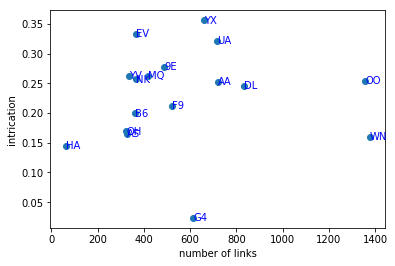

In [89]:
nlinks2=[nlinks[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(nlinks2,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('number of links')
print(cov3)
ni=0
for i in carL:
    text = axes.text(nlinks2[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

## Covariance

[ 0.22073867  0.02197596 -0.01878084 -0.04324019  0.08617365  0.16609728
 -0.10736238 -0.10571059 -0.00288777  0.13080882 -0.07876284  0.01608087
  0.65894791  0.13491643 -0.57296667  0.07669357  0.28405015]


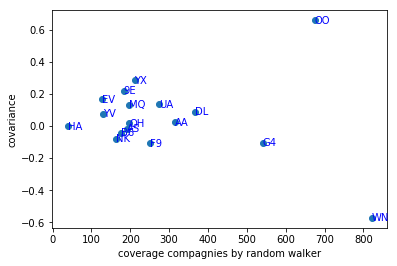

In [90]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectpcov,'o')
axes.set_ylabel('covariance')
axes.set_xlabel('coverage compagnies by random walker')
print(vectpcov)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectpcov[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

## Precision

[183, 315, 192, 175, 366, 128, 252, 541, 39, 198, 164, 197, 675, 275, 822, 129, 211]


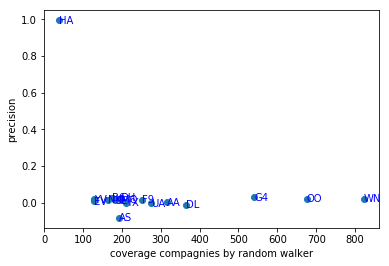

In [91]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectpprec,'o')
axes.set_ylabel('precision')
axes.set_xlabel('coverage compagnies by random walker')
print(cov3)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectpprec[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

# Probas de transition

L'idée est de calculer, une fois arrivé à un aéroport $a$ à un temps $t0$, la probabilité de prendre les vols à suivre en fonction du temps qu'il faut attendre pour cela. On considère qu'on peut prendre un lien qu'un certain temps après le temps $t2$ étudié, dans ce qu'on appellera une fenêtre. On va favoriser les vols partant le plus tôt. La probabilité de prendre un vol partant pour $b$ à $t$ sera donc: $p((t,a,b))=(t2-t)/c \times \delta_{t0<t<t2}$, avec $\sum_{\forall (t,a,b)\in E} p((t,a,b))=1$.

En calculant cela pour tous les aéroports de départ, nous obtenons une matrice d'adjacence entre les aéroports. Nous pouvons donc en tirer un vecteur propre pour la valeur propre 1, et un classement des aéroports les plus "influents", ceux dans lesquels il est le plus probable qu'un voyageur aléatoire atterrisse.


In [92]:
pt1,pt2=m.calculMatriceProbaTransition(7*60,60*24)
#m.printMS()
print(pt1)
matAirp=np.array(pt1)
matAirp=np.transpose(matAirp)
print(len(pt1))
valptrans,vectptrans=valeurPropreMax(matAirp,100000)

['9E']
0
['OH']
11
['OH']
11
['OH']
11
['OO']
12
['OO']
12
['G4']
7
['G4']
7
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['UA']
13
['WN']
14
['WN']
14
['YX']
16
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YV']
15
['YV']
15
['WN']
14
['WN']
14
['WN']
14
['EV']
5
['EV']
5
['EV']
5
['OO']
12
['B6']
3
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['WN']
14
['WN']
14
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['MQ']
9
['YX']
16
['OO']
12
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YV']
15
['YV']
15
['YV']
15
['WN']
14
['AS']
2
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['AS']
2
['AS']
2
['9E']
0
['9E']
0
['9E']
0
['MQ']
9
['MQ']
9
['EV'

['DL']
4
['9E']
0
['9E']
0
['9E']
0
['9E']
0
['OO']
12
['MQ']
9
['OO']
12
['OO']
12
['G4']
7
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['B6']
3
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['F9']
6
['OO']
12
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YX']
16
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['9E']
0
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['UA']
13
['WN']
14
['YX']
16
['YX']
16
['B6']
3
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['F9']
6
['UA']
13
['YV']
15
['YV']
15
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['YV']
15
['AA']
1
['B6']
3
['B6']
3
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['

['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['UA']
13
['B6']
3
['NK']
10
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['NK']
10
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['EV']
5
['EV']
5
['EV']
5
['AS']
2
['AS']
2
['OO']
12
['OO']
12
['9E']
0
['9E']
0
['9E']
0
['OO']
12
['OH']
11
['OH']
11
['OO']
12
['EV']
5
['EV']
5
['MQ']
9
['OO']
12
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['9E']
0
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['YX']
16
['9E']
0
['EV']
5
['EV']
5
['YV']
15
['YV']
15
['9E']
0
['9E']
0
['B6']
3
['B6']
3
['B6']
3
['9E']
0
['EV']
5
['UA']
13
['UA']
13
['UA']
13
['DL']
4
['DL']
4
['DL']
4
['B6']
3
['B6']
3
['B6']
3
['YX']
16
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['OH']
11
['YX']
16
['YX']
16
['AA']
1
['DL']
4
['DL']
4
['UA']
13
['B6']
3
['WN']
14
['YV']
15
['YV']
15
['9E']
0
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['OO']
12
['OO']
12
['B6']
3
['9E']
0
['9E']
0
['OO']
12
['B6']
3
['F9']
6
['WN']
14
['WN']
14
['WN']
14

['MQ']
9
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['MQ']
9
['MQ']
9
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['AA']
1
['AA']
1
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['AA']
1
['AA']
1
['MQ']
9
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['YX']
16
['YX']
16
['YX']
16
['YX']
16
['YX']
16
['MQ']
9
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['WN']
14
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YX']
16
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['OO']
12
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['OH']
11
['OH']
11
['OH']
11
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['OH']
11
['OH']
11
['OH']
11
['OH'

['OH']
11
['OH']
11
['OH']
11
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YX']
16
['YX']
16
['YX']
16
['YX']
16
['WN']
14
['B6']
3
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['YX']
16
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['OH']
11
['YX']
16
['YX']
16
['YX']
16
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['B6']
3
['YX']
16
['YX']
16
['EV']
5
['EV']
5
['OH']
11
['OH']
11
['OH']
11
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YX']
16
['WN']
14
['WN']
14
['YX']
16
['YX']
16
['OH']
11
['OH']
11
['OH']
11
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OH']
11
['OH']
11
['F9']
6
['F9']
6
['F9']
6
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['OH']
11
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['YX']
16
['EV']
5
['EV']
5
['EV']
5
['YX']
16
['YX']


['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['UA']
13
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['F9']
6
['F9']
6
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['WN']
14
['WN']
14
['YX']
16
['YX']
16
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['WN']
14
['WN']
14
['OO']
12
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YV']
15
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['MQ']
9
['YV']
15
['YV']
15
['YV']
15
['MQ']

['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['EV']
5
['EV']
5
['EV']
5
['WN']
14
['EV']
5
['DL']
4
['OO']
12
['OO']
12
['OO']
12
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['9E']
0
['9E']
0
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YV']
15
['YV']
15
['YV']
15
['WN']
14
['WN']
14
['WN']
14
['EV']
5
['EV']
5
['OO']
12
['YV']
15
['YV']
15
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['MQ']
9
['MQ']
9
['MQ']
9
['YX']
16
['YX']
16
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['WN']
14
['WN']
14
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['G4']
7
['OO']
12
['UA']
13
['OO']
12
['OO']
12
['G4']
7
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['9E']
0
['O

['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['G4']
7
['G4']
7
['9E']
0
['G4']
7
['OO']
12
['OO']
12
['YX']
16
['YV']
15
['DL']
4
['OO']
12
['OO']
12
['MQ']
9
['OO']
12
['OO']
12
['YX']
16
['YV']
15
['9E']
0
['9E']
0
['MQ']
9
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['OO']
12
['G4']
7
['G4']
7
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['WN']
14
['WN']
14
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['AA']
1
['WN']
14
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['UA']
13
['AA']
1
['AA']
1
['WN']
14
['OO']
12
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['DL']
4
['DL']
4
['OO']
12
['OO']
12
['WN']
14
['DL']
4
['OO']
12
['WN']
14
['G4']
7
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['YX']
16
['YX']
16
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['9E']
0
['9E']
0
['9E']
0
['OO']
12
['OH']
11
['O

['YX']
16
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['YV']
15
['YV']
15
['EV']
5
['EV']
5
['OO']
12
['YV']
15
['EV']
5
['OO']
12
['UA']
13
['YV']
15
['YX']
16
['YV']
15
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['NK']
10
['UA']
13
['UA']
13
['YV']
15
['EV']
5
['EV']
5
['YV']
15
['YV']
15
['UA']
13
['UA']
13
['YX']
16
['EV']
5
['EV']
5
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['YV']
15
['YV']
15
['YV']
15
['YX']
16
['YV']
15
['YX']
16
['YX']
16
['EV']
5
['EV']
5
['OO']
12
['EV']
5
['EV']
5
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YX']
16
['YX']
16
['EV']
5
['UA']
13
['UA']
13
['UA']
13
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['F9']
6
['NK']
10
['NK']
10
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['YV']
15
['YV'

['DL']
4
['DL']
4
['DL']
4
['9E']
0
['9E']
0
['B6']
3
['B6']
3
['AA']
1
['AS']
2
['AS']
2
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['AA']
1
['AA']
1
['AA']
1
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['AS']
2
['B6']
3
['DL']
4
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['B6']
3
['DL']
4
['9E']
0
['B6']
3
['DL']
4
['9E']
0
['B6']
3
['B6']
3
['YX']
16
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['UA']
13
['AA']
1
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['HA']
8
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['HA']
8
['UA']
13
['U

['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['MQ']
9
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['EV']
5
['EV']
5
['WN']
14
['NK']
10
['NK']
10
['NK']
10
['NK']
10
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['EV']
5
['EV']
5
['EV']
5
['G4']
7
['G4']
7
['9E']
0
['DL']
4
['DL']
4
['DL']
4
['OO']
12
['MQ']
9
['OH']
11
['OH']
11
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['G4']
7
['EV']
5
['EV']
5
['EV']
5
['MQ']
9
['MQ']
9
['OH']
11
['OO']
12
['G4']
7
['G4']
7
['G4']
7
['9E']
0
['OO']
12
['MQ']
9
['YV']
15
['YV']
15
['EV']
5
['EV']
5
['EV']
5
['EV']
5
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['F9']
6
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YX']
16
['YX']
16
['YX']
16
['YX']
16
['9E']
0
['OO']
12
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['YX']
16
['YX']
16
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['B6']
3
['B6']

15
['F9']
6
['MQ']
9
['OO']
12
['OO']
12
['G4']
7
['G4']
7
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN

['UA']
13
['UA']
13
['NK']
10
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
['NK']
10
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['NK']
10
['WN']
14
['WN']
14
['WN']
14
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['NK']
10
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['YX']
16
['DL']
4
['WN']
14
['AA']
1
['NK']
10
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['F9']
6
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AS']
2
['AS']
2
['UA']
13
['DL']
4
['WN']
14
['WN']
14
['NK']
10
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['DL']
4
['AA']
1
['MQ']
9
['YV']
15
['UA']
13
['YV']
15
['OO']
12
['YV']
15
['OO']
12
['OO']
12
['NK']
10
['9E']
0
['DL']
4
['NK']
10
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['YX']
16
['NK']
10
['NK']
10
['NK']
10
['OH']
11
['9E']
0
['9E']
0
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
['OH']
11
[

16
['YX']
16
['MQ']
9
['MQ']
9
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['F9']
6
['F9']
6
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['EV']
5
['MQ']
9
['MQ']
9
['MQ']
9
['EV']
5
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['OO']
12
['OO']
12
['UA']
13
['UA']
13
['UA']
13
['YX']
16
['AA']
1
['NK']
10
['UA']
13
['UA']
13
['OO']
12
['UA']
13
['EV']
5
['EV']
5
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['MQ']
9
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['OO']
12
['UA']
13
['UA']
13
['YX']
16
['YX']
16
['OO']
12
['YX']
16
['YX']
16
['YX']
16
['OO']
12
['OO']
12
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AS']
2
['AS']
2
['AS']
2
['UA']
13
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA'

1
['B6']
3
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['YV']
15
['YV']
15
['YV']
15
['AA']
1
['AA']
1
['WN']
14
['WN']
14
['WN']
14
['F9']
6
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['WN']
14
['F9']
6
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['F9']
6
['F9']
6
['F9']
6
['OO']
12
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['NK']
10
['YV']
15
['YV']
15
['YV']
15
['AA']
1
['AA']
1
['F9']
6
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['DL']
4
['DL']
4
['WN']
14
['OO']
12
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['YV']
15
['OO']
12
['AA']
1
['AA']
1
['AA']
1
['AA']
1

['OO']
12
['OO']
12
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['B6']
3
['B6']
3
['B6']
3
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['OH']
11
['OH']
11
['OH']
11
['UA']
13
['UA']
13
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['9E']
0
['EV']
5
['EV']
5
['B6']
3
['B6']
3
['NK']
10
['EV']
5
['YV']
15
['YV']
15
['9E']
0
['9E']
0
['OO']
12
['OO']
12
['B6']
3
['B6']
3
['NK']
10
['YX']
16
['YX']
16
['9E']
0
['EV']
5
['EV']
5
['MQ']
9
['MQ']
9
['MQ']
9
['OO']
12
['UA']
13
['OO']
12
['OO']
12
['DL']
4
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['YV']
15
['B6']
3
['G4']
7
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['B6']
3
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['AA']
1
['AA']
1
['AA']
1
['WN']
14
['WN']
14
['YV']
15
['YV']
15
['WN']
14
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['UA']
13
['OO'

['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['DL']
4
['DL']
4
['DL']
4
['DL']
4
['UA']
13
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['UA']
13
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['AS']
2
['B6']
3
['B6']
3
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['AS']
2
['DL']
4
['HA']
8
['HA']
8
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['AS']
2
['AS']
2
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['OO']
12
['OO']
12
['AA']
1
['AA']
1
['AA']
1
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['B6']
3
['B6']
3
['B6']
3
['B6']
3
['DL']
4
['DL']
4
['DL']
4
[

14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['AS']
2
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['OO']
12
['OO']
12
['OO']
12
['UA']
13
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['DL']
4
['DL']
4
['DL']
4
['WN']
14
['F9']
6
['UA']
13
['UA']
13
['UA']
13
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['UA']
13
['WN']
14
['UA']
13
['UA']
13
['UA']
13
['UA']
13
['DL']
4
['OO']
12
['OO']
12
['OO']
12
['OO']
12
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['DL']
4
['DL']
4
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['UA']
13
['UA']
13
['UA']
13
['AS']
2
['AS']
2
['AS']
2
['AA']
1
['AA']
1
['AA']
1
['AA']
1
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14
['WN']
14

['OO']
12
['OO']
12
['OO']
12
['OO']
12
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01160092807424594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40119876256767206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17072699149265275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

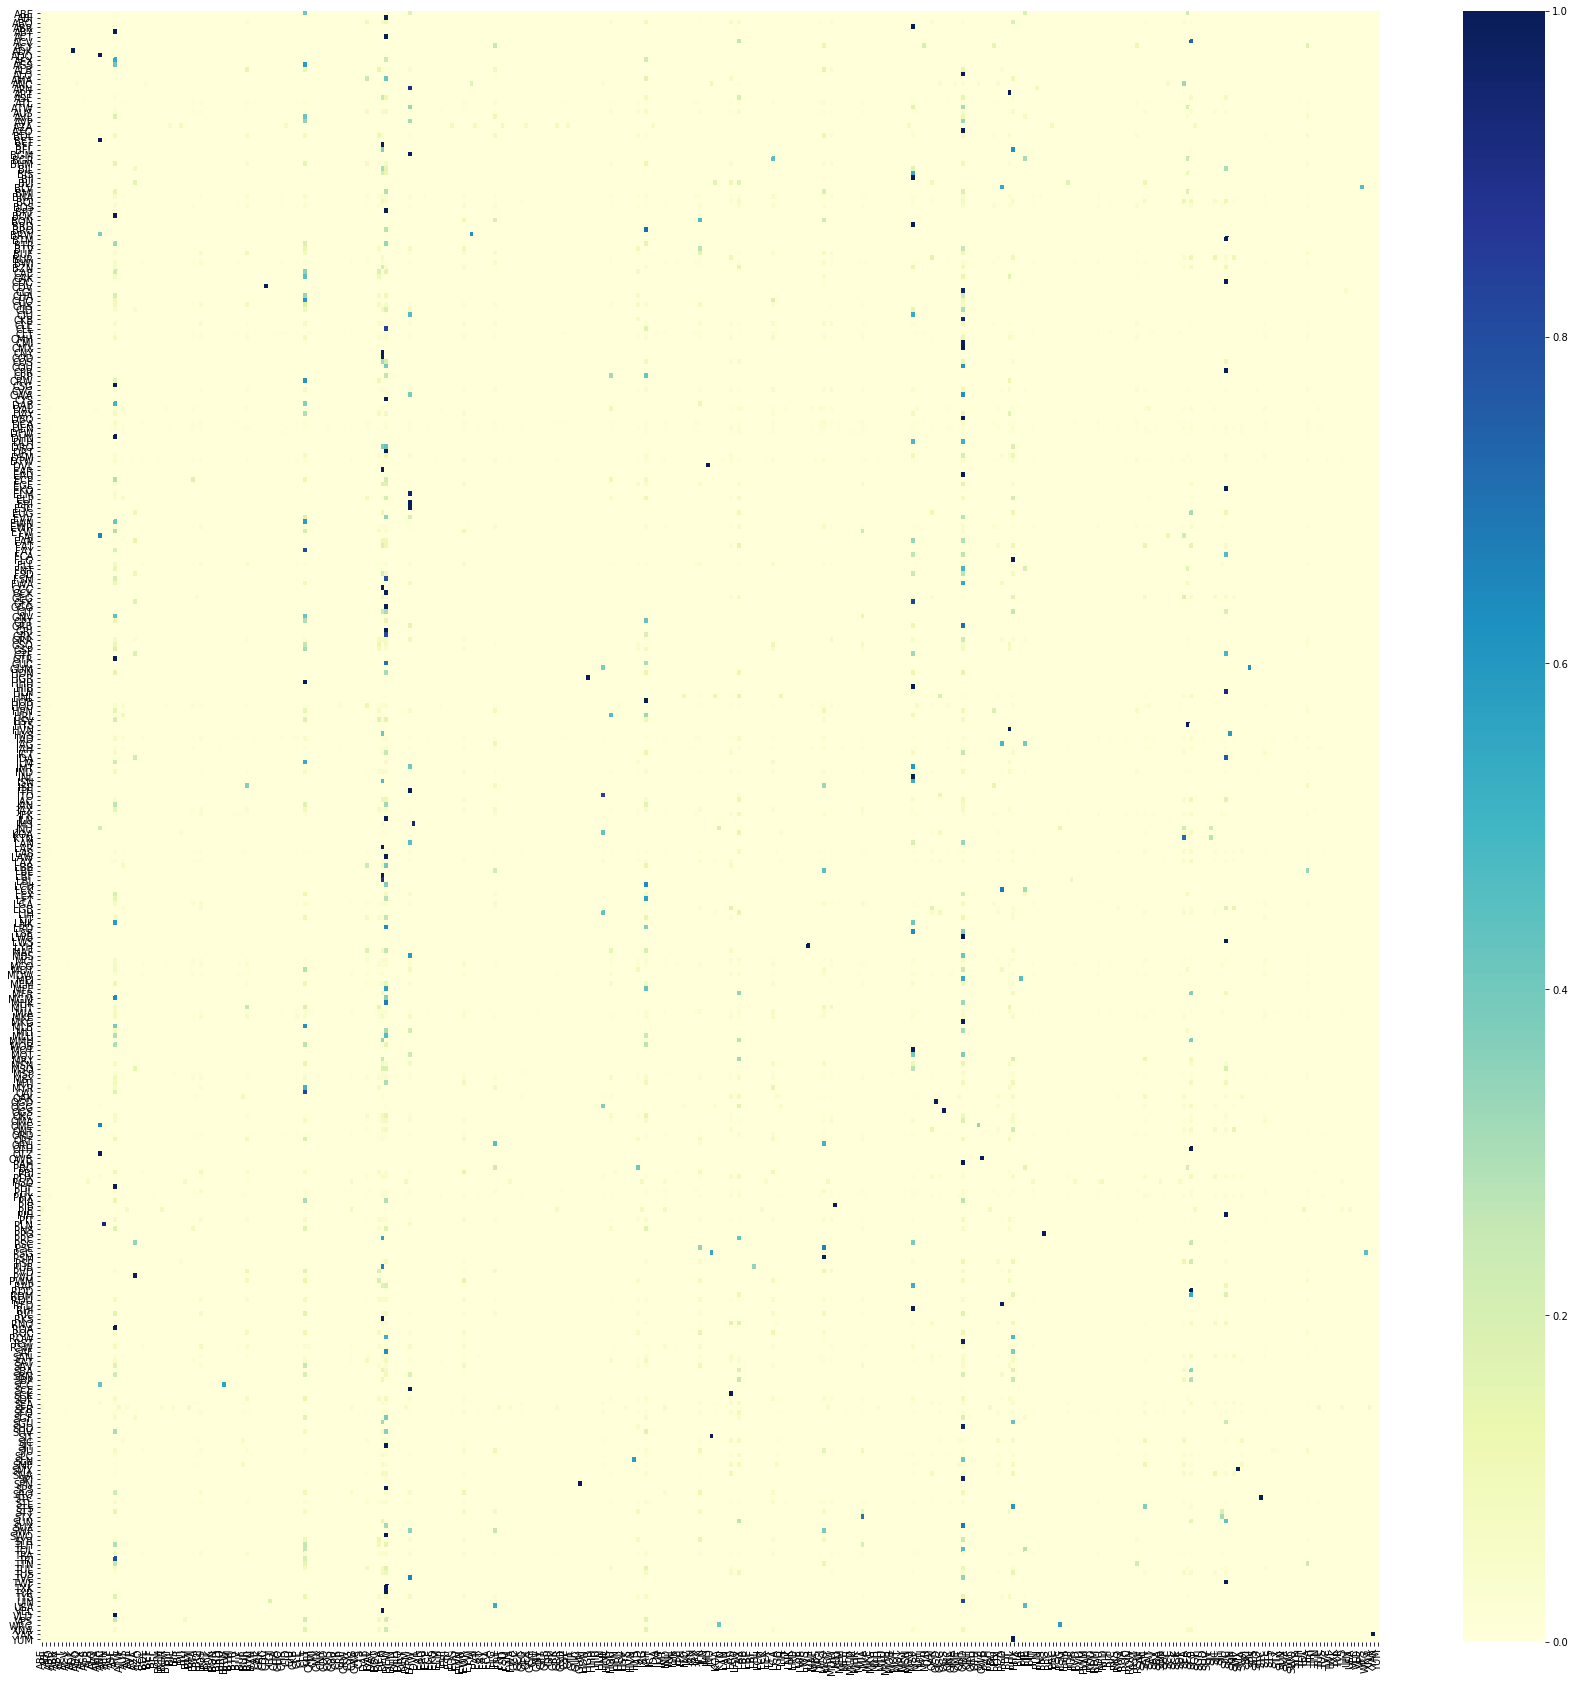

In [93]:
sns_plot=sns.heatmap(np.transpose(matAirp),cmap="YlGnBu",xticklabels=airportl,yticklabels=airportl)
fig = sns_plot.get_figure()
fig.set_size_inches(30,30)
plt.show()


Comparaison avec le Random walk. Ca marche quand le temps est très grand (1 jour)

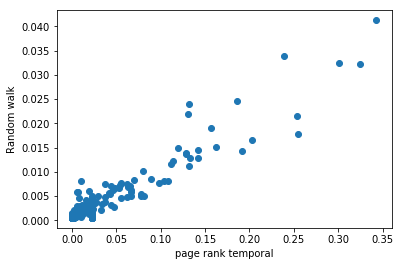

In [94]:
axes = plt.gca()
plt.plot(vectptrans,pr,'o')
axes.set_ylabel('Random walk')
axes.set_xlabel('page rank temporal')
plt.savefig("randwalkVStpr.pdf")
plt.show()

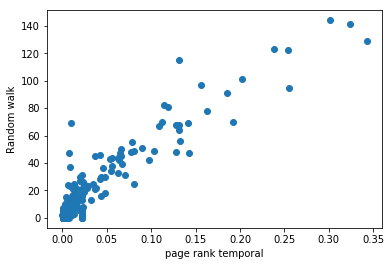

In [95]:
axes = plt.gca()
plt.plot(vectptrans,covAirports,'o')
axes.set_ylabel('Random walk')
axes.set_xlabel('page rank temporal')
plt.savefig("randwalkVStpr.pdf")
plt.show()

A partir de ça, on va calculer une autre matrice de covariance. On a aussi calculé la probabilité de prendre telle ou telle compagnie à partir de chaque aéroport, ce qui nous donne un échantillon (de taille le nombre d'aéroports) de variables aléatoires correspondant à la probabilité de choisir une compagnie. et on peut encore en faire plus sur le temps si on veut.


0.8859293059238494
0.7354268427947388
0.8395820165127741
0.4928512872812008
0.6543504567708249
0.6521192003664453
0.22291250836578821
0.9988764404330807
0.18809523275261503
1.9130184023494012
0.24305222641120774
1.0634011202274611
5.584462842555128
0.5535836933006653
1.3901358025853245
0.6478093202616071
0.38310437613737847
0.7354268427947388
0.6345091034062857
0.7139693074812025
0.42047280897490785
0.558128515004444
0.5532593098512363
0.18965782240721132
0.8473437090589114
0.16039275030733616
1.622551115238916
0.20701189050129573
0.9002303227986628
4.742428445842022
0.4732367260455438
1.1858736659359923
0.5501798643229148
0.3261959179241857
0.8395820165127741
0.7139693074812025
0.8538807360547507
0.4782039594275748
0.6352000887918291
0.6314849891123717
0.21618777127793606
0.968675757609872
0.1836285003805214
1.853132816400897
0.2358668467937791
1.0264777122722544
5.418049673778815
0.5381163017246561
1.350519585524099
0.6275259482634082
0.3710315043448063
0.4928512872812008
0.420472808

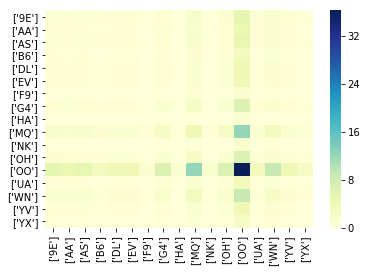

[0.24435285 0.24547554 0.24178171 0.24218736 0.24566665 0.24426977
 0.23578579 0.24296933 0.22984286 0.2450573  0.23710706 0.24476974
 0.24596942 0.24413109 0.24537873 0.24467983 0.24306127]



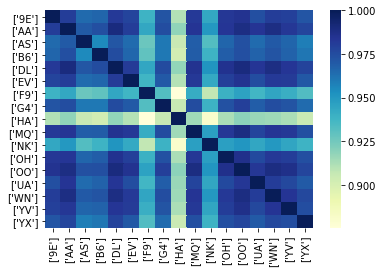

In [96]:
from math import *

matcovtemp=[[0 for j in carL] for i in carL]
avg=[0. for i in carL]

for i in range(len(carL)):
    moy=0
    for k in range(len(airportl)):
        moy+=pt2[k][i]
    avg[i]=moy/(len(carL))

for i in range(len(carL)):
    for j in range(len(carL)):
        moyprod=0
        moyi=0
        moyj=0
        for k in range(len(airportl)):
            moyprod+=(pt2[k][i]-avg[i])*(pt2[k][j]-avg[j])
        print(moyprod/(len(airportl)))
        matcovtemp[i][j]=(moyprod)/(len(pt2))

lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matcovtemp),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
plt.savefig("covarianceMatrix2019.pdf")
plt.show()

for i in range(len(carL)):
    for j in range(len(carL)):
        if i!=j:
            matcovtemp[i][j]=matcovtemp[i][j]/(sqrt(matcovtemp[i][i])*sqrt(matcovtemp[j][j]))
for i in range(len(carL)):
    matcovtemp[i][i]=1

sns_plot=sns.heatmap(np.transpose(matcovtemp),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
plt.savefig("cov2019.pdf")

vecptransC=[0 for i in carL]
for i in range(len(vecptransC)):
    for j in range(len(vecptransC)):
        vecptransC[i]+=matcovtemp[i][j]

vecptransC=valeurPropreMax(matcovtemp,1000)[1]
print(vecptransC)

print()

[183, 315, 192, 175, 366, 128, 252, 541, 39, 198, 164, 197, 675, 275, 822, 129, 211]


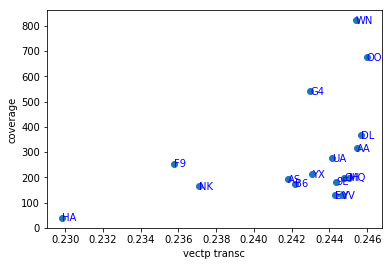

In [97]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(vecptransC,cov3,'o')
axes.set_ylabel('coverage')
axes.set_xlabel('vectp transc')
print(cov3)
ni=0
for i in carL:
    text = axes.text(vecptransC[ni],cov3[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

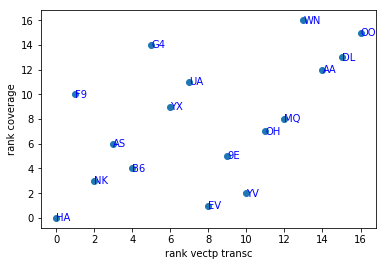

In [98]:
vecptransordo=sorted(vecptransC)
cov3ordo=sorted(cov3)
ordrevecptrans=[vecptransordo.index(vecptransC[i]) for i in range(len(vecptransC))]
ordrecov3=[cov3ordo.index(cov3[i]) for i in range(len(cov3))]
plt.plot(ordrevecptrans,ordrecov3,'o')
axes=plt.gca()
axes.set_ylabel('rank coverage')
axes.set_xlabel('rank vectp transc')
ni=0
for i in carL:
    text = axes.text(ordrevecptrans[ni],ordrecov3[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.savefig("rank2019.pdf")
plt.show()


[[0.53921569]] [3.68627451]


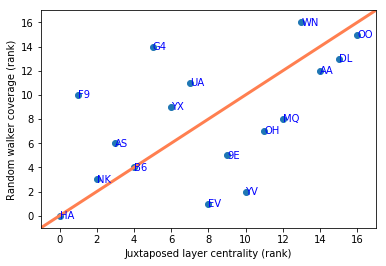

1.0006443408892398


In [99]:
from sklearn import linear_model

import matplotlib.pyplot as plt
import numpy as np
import random

#----------------------------------------------------------------------------------------#
# Step 1: training data

X = ordrevecptrans
Y = ordrecov3

X = np.asarray(X)
Y = np.asarray(Y)

X = X[:,np.newaxis]
Y = Y[:,np.newaxis]

plt.scatter(X,Y)

#----------------------------------------------------------------------------------------#
# Step 2: define and train a model

model = linear_model.LinearRegression()
model.fit(X, Y)

print(model.coef_, model.intercept_)

#----------------------------------------------------------------------------------------#
# Step 3: prediction

x_new_min = -1.0
x_new_max = 17.0

X_NEW = np.linspace(x_new_min, x_new_max, 100)
X_NEW = X_NEW[:,np.newaxis]

#Y_NEW = [model.predict(X_NEW)]
Y_NEW=X_NEW #without prediction : x=y

plt.plot(X_NEW, Y_NEW, color='coral', linewidth=3)


plt.xlim(-1,17)
plt.ylim(-1,17)

#plt.title("Simple Linear Regression using scikit-learn and python 3",fontsize=10)
plt.xlabel('Juxtaposed layer centrality (rank)')
plt.ylabel('Random walker coverage (rank)')

axes=plt.gca()
ni=0
for i in carL:
    text = axes.text(ordrevecptrans[ni],ordrecov3[ni],i,ha="left", va="center", color="b")
    ni=ni+1

plt.savefig("simple_linear_regression2019.pdf", bbox_inches='tight')
plt.show()

#step 4 score 

s=0
for i in range(len(X)):
    s=s+(Y[i]-X[i]*model.coef_-model.intercept_)**2

print(sqrt(s)/(len(X)))

# Nombre de vols par compagnies

NameError: name 'nbvols' is not defined

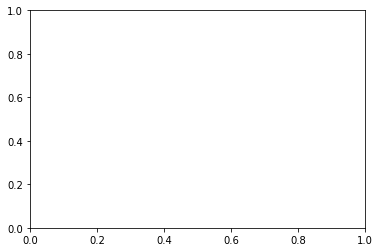

In [100]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(nbvols,cov3,'o')
axes.set_ylabel('coverage')
axes.set_xlabel('nbvols')
print(cov3)
ni=0
for i in carL:
    text = axes.text(nbvols[ni],cov3[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

In [ ]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
#plt.plot(nbvols,cov3,'o')
plt.plot(nbvols,vecptransC,'o')
axes.set_ylabel('vecptransC')
axes.set_xlabel('nbvols')
print(cov3)
ni=0
for i in carL:
    text = axes.text(nbvols[ni],vecptransC[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

In [ ]:
nbvols=[0 for i in carL]

for link in m.giveLinks().giveListOfLinks():
    nbVols=(len(link.giveIntervals()))
    carIndex=carL.index(link.giveLabel()[2][0])
    nbvols[carIndex]=nbvols[carIndex]+nbVols

print(nbvols)
print(carL)
tot=0
for i in range(len(nbvols)):
    tot=tot+nbvols[i]
print(tot)
plt.plot(carL,nbvols,'o')
plt.show()